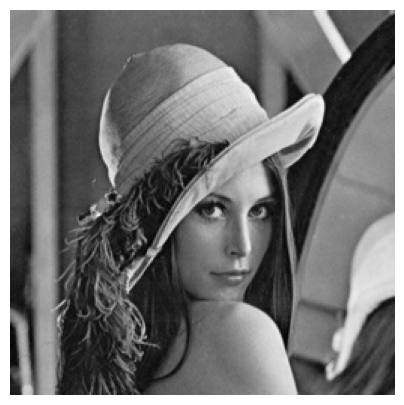

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
import tools
import cv2

# 读取灰度图
image = Image.open("lina.jpg").convert('L')  # 替换为你的灰度图路径
resized_image = image.resize((256, 256))

# 显示第四种压缩方法的图像
plt.figure(figsize=(5, 5))
plt.imshow(resized_image, cmap='gray')
plt.axis('off')
plt.show()


In [2]:
import numpy as np
QY = [
    [16, 11, 10, 16, 24, 40, 51, 61],
    [12, 12, 14, 19, 26, 58, 60, 55],
    [14, 13, 16, 24, 40, 57, 69, 56],
    [14, 17, 22, 29, 51, 87, 80, 62],
    [18, 22, 37, 56, 68, 109, 103, 77],
    [24, 35, 55, 64, 81, 104, 113, 92],
    [49, 64, 78, 87, 103, 121, 120, 101],
    [72, 92, 95, 98, 112, 100, 103, 99]
]
QY = np.array(QY)
QY

array([[ 16,  11,  10,  16,  24,  40,  51,  61],
       [ 12,  12,  14,  19,  26,  58,  60,  55],
       [ 14,  13,  16,  24,  40,  57,  69,  56],
       [ 14,  17,  22,  29,  51,  87,  80,  62],
       [ 18,  22,  37,  56,  68, 109, 103,  77],
       [ 24,  35,  55,  64,  81, 104, 113,  92],
       [ 49,  64,  78,  87, 103, 121, 120, 101],
       [ 72,  92,  95,  98, 112, 100, 103,  99]])

In [3]:
def generate_slant_mask(n, m=8):
    mask = np.zeros((m, m), dtype=int)

    for i in range(m):
        for j in range(m):
            if i + j < n:
                mask[i][j] = 1

    return mask

In [4]:
import numpy as np
# 将图像分割成8x8块
blocks = [
    np.array(resized_image)[j:j + 8, i:i + 8] for j in range(0, 256, 8) for i in range(0, 256, 8)
]

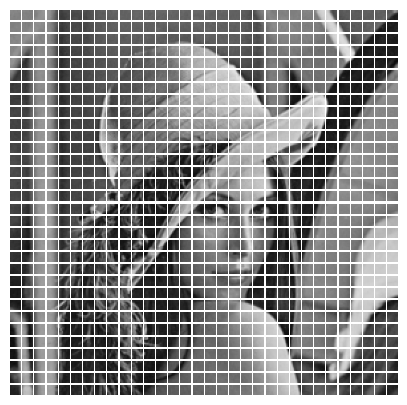

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# 可视化分割效果
num_blocks = len(blocks)
rows = int(np.ceil(num_blocks / 32))  # 每行显示8个块
fig, axes = plt.subplots(rows, 32, figsize=(5, 5))

for i in range(rows):
    for j in range(32):
        ax = axes[i, j] if rows > 1 else axes[j]
        ax.imshow(blocks[i * 32 + j], cmap='gray', vmin=0, vmax=255)
        ax.axis('off')

# 删除多余的子图
for i in range(num_blocks, rows * 32):
    fig.delaxes(axes.flatten()[i])

plt.show()


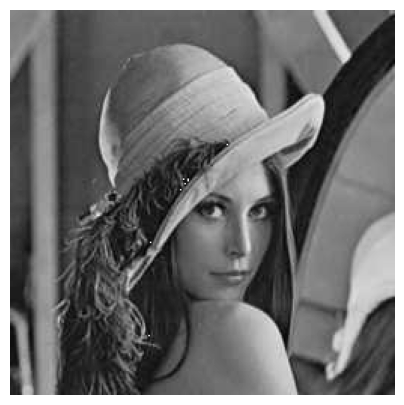

True

In [6]:

compressed_signals_2_1 = []

for block in blocks:
    dct_block = tools.dct2d(block)
    dct_block = generate_slant_mask(8) * dct_block
    quantized_block = np.round(dct_block / QY)  # 量化
    zigzag_result = tools.zigzag_scan(quantized_block)  # ZigZag
    compressed_dct_signal = tools.dpcm_encode(zigzag_result)  # DPCM
    compressed_signals_2_1.append(compressed_dct_signal)

# 逆DCT重建压缩后的图像
reconstructed_image_2_1 = np.zeros((256, 256))

for idx, signal in enumerate(compressed_signals_2_1):
    y, x = divmod(idx, 32)
    decode_signal = tools.dpcm_decode(signal)
    reconstructed_matrix = tools.zigzag_reverse(decode_signal, 8, 8)
    reconstructed_image_2_1[y * 8:y * 8 + 8, x * 8:x * 8 + 8] = tools.idct2d(reconstructed_matrix * QY)

# 显示第一种压缩方法的图像
plt.figure(figsize=(5, 5))
plt.imshow(reconstructed_image_2_1.astype('uint8'), cmap='gray')
# plt.title('Method 2.1: Keeping selected DCT coefficients')
plt.axis('off')
plt.show()

cv2.imwrite('2_1.png', reconstructed_image_2_1)

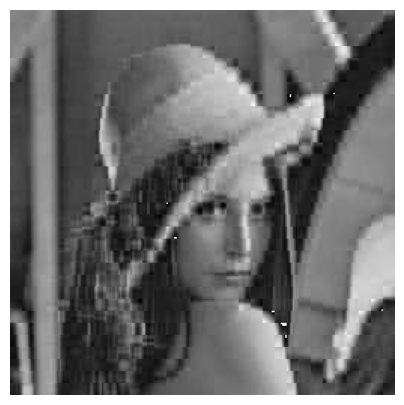

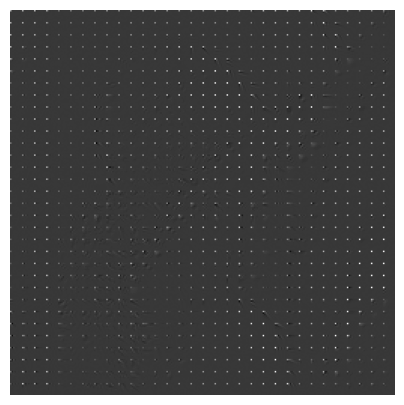

True

In [7]:
compressed_signals_2_2 = []
visualized_dct_blocks = np.zeros((256, 256))

for idx, block in enumerate(blocks):
    y, x = divmod(idx, 32)
    dct_block = tools.dct2d(block)
    visualized_dct_blocks[y * 8:y * 8 + 8, x * 8:x * 8 + 8] = dct_block
    # 保留直流分量，置零交流分量
    dct_block[1:, 1:] = 0  # 保留原点处，其他置零
    quantized_block = np.round(dct_block / QY) # 量化
    zigzag_result = tools.zigzag_scan(quantized_block)  # ZigZag
    compressed_dct_signal = tools.dpcm_encode(zigzag_result)  # DPCM
    compressed_signals_2_2.append(compressed_dct_signal)

# 逆DCT重建压缩后的图像
reconstructed_image_2_2 = np.zeros((256, 256))

for idx, signal in enumerate(compressed_signals_2_2):
    y, x = divmod(idx, 32)
    decode_signal = tools.dpcm_decode(signal)
    reconstructed_matrix = tools.zigzag_reverse(decode_signal, 8, 8)
    reconstructed_image_2_2[y * 8:y * 8 + 8, x * 8:x * 8 + 8] = tools.idct2d(reconstructed_matrix * QY)

# 显示第二种压缩方法的图像
plt.figure(figsize=(5, 5))
plt.imshow(reconstructed_image_2_2.astype('uint8'), cmap='gray')
# plt.title('Method 2.2: Keeping DC coefficients only')
plt.axis('off')
plt.show()

cv2.imwrite('2_2.png', reconstructed_image_2_2)


plt.figure(figsize=(5, 5))
plt.imshow(visualized_dct_blocks, cmap='gray')
# plt.title('DCT Transformed Blocks')
plt.axis('off')
plt.show()

cv2.imwrite('2_2_dct.png', visualized_dct_blocks)

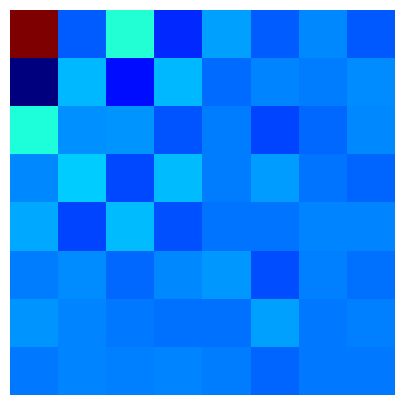

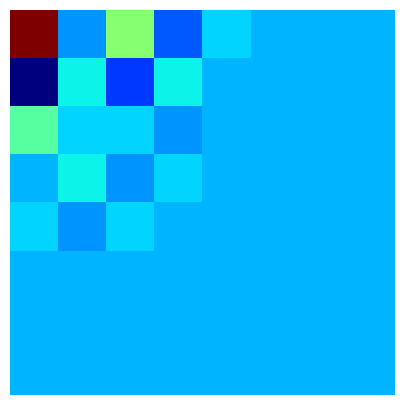

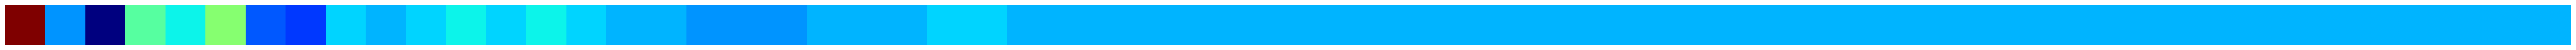

In [18]:
x, y = 16, 16
size = 8
block = visualized_dct_blocks[y * size:y * size+ size, x * size:x * size + size]
plt.figure(figsize=(5, 5))
plt.imshow(block, extent=[y * size, y * size + size, x * size, x * size + size], cmap='jet')
# plt.title('DCT Transformed Blocks')
plt.axis('off')
plt.show()

QY_block = np.round(block / QY)
plt.figure(figsize=(5, 5))
plt.imshow(QY_block, extent=[y * size, y * size + size, x * size, x * size + size], cmap='jet')
# plt.title('DCT Transformed Blocks')
plt.axis('off')
plt.show()

zigzag_r = tools.zigzag_scan(QY_block)
plt.figure(figsize=(64, 2))
plt.imshow(zigzag_r.reshape(1, 64), cmap='jet')
# plt.title('DCT Transformed Blocks')
plt.axis('off')
plt.show()

# cv2.imwrite('2_2_dct_part.png', visualized_dct_blocks[y * size:y * size+ size, x * size:x * size + size])


In [9]:
import cv2
# 缩放为256x256的量化表
QY_256 = cv2.resize(cv2.merge([QY.astype(np.uint8)]), (256, 256), interpolation=cv2.INTER_LINEAR)

# 将OpenCV数组转换为Numpy数组
QY_256 = np.array(QY_256)

QY_256

array([[16, 16, 16, ..., 61, 61, 61],
       [16, 16, 16, ..., 61, 61, 61],
       [16, 16, 16, ..., 61, 61, 61],
       ...,
       [72, 72, 72, ..., 99, 99, 99],
       [72, 72, 72, ..., 99, 99, 99],
       [72, 72, 72, ..., 99, 99, 99]], dtype=uint8)

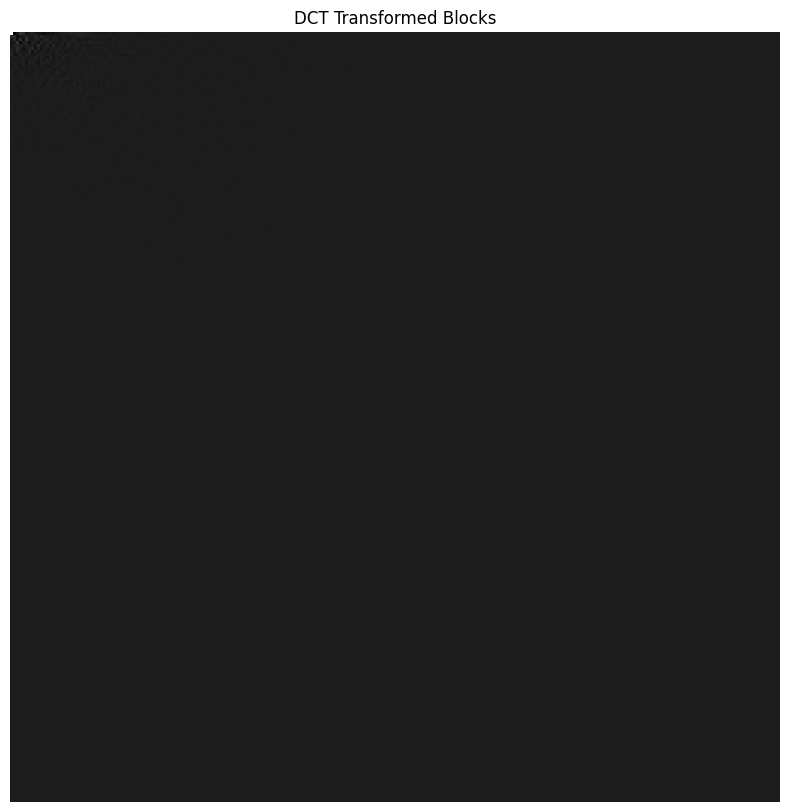

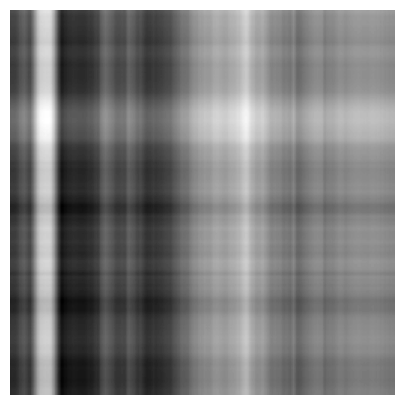

True

In [10]:
dct_full = cv2.dct(np.array(resized_image).astype('float32'))

plt.figure(figsize=(10, 10))
plt.imshow(dct_full * 256, cmap='gray')
plt.title('DCT Transformed Blocks')
plt.axis('off')
plt.show()

dct_full[1:, 1:] = 0  # 保留原点处，其他置零
quantized_result = np.round(dct_full / QY_256)  # 量化
zigzag_result = tools.zigzag_scan(quantized_result)  # ZigZag
compressed_dct_full = tools.dpcm_encode(zigzag_result)  # DPCM

decode_signal = tools.dpcm_decode(compressed_dct_full)
reconstructed_matrix = tools.zigzag_reverse(decode_signal, 256, 256)
reconstructed_image_2_3 = cv2.idct(reconstructed_matrix * QY_256)  # IDCT

# 显示第三种压缩方法的图像
plt.figure(figsize=(5, 5))
plt.imshow(reconstructed_image_2_3.astype('uint8'), cmap='gray')
# plt.title('Method 2.3: Keeping DC coefficient only for the whole image')
plt.axis('off')
plt.show()

cv2.imwrite('2_3.png', reconstructed_image_2_3)

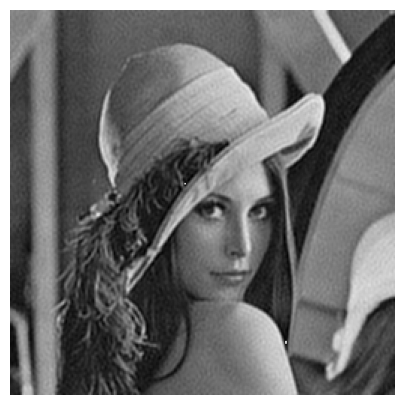

True

In [11]:
dct_select = cv2.dct(np.array(resized_image).astype('float32'))

dct_select = generate_slant_mask(400, m=256) * dct_select  # 除原点外，自行选择保留有限个交流分量

quantized_result = np.round(dct_select / QY_256)  # 量化
zigzag_result = tools.zigzag_scan(quantized_result)  # ZigZag
compressed_dct_full = tools.dpcm_encode(zigzag_result)  # DPCM

decode_signal = tools.dpcm_decode(compressed_dct_full)
reconstructed_matrix = tools.zigzag_reverse(decode_signal, 256, 256)
reconstructed_image_2_4 = cv2.idct(reconstructed_matrix * QY_256)  # IDCT

# 显示第四种压缩方法的图像
plt.figure(figsize=(5, 5))
plt.imshow(reconstructed_image_2_4.astype('uint8'), cmap='gray')
# plt.title('Method 2.4: Selective AC coefficient preservation')
plt.axis('off')
plt.show()


cv2.imwrite('2_4.png', reconstructed_image_2_4)


In [12]:
print(f"0-1 MSE: {tools.mse(resized_image, reconstructed_image_2_1)}")
print(f"0-1 PSNR: {tools.psnr(resized_image, reconstructed_image_2_1)}")

print(f"0-2 MSE: {tools.mse(resized_image, reconstructed_image_2_2)}")
print(f"0-2 PSNR: {tools.psnr(resized_image, reconstructed_image_2_2)}")

print(f"0-3 MSE: {tools.mse(resized_image, reconstructed_image_2_3)}")
print(f"0-3 PSNR: {tools.psnr(resized_image, reconstructed_image_2_3)}")

print(f"0-4 MSE: {tools.mse(resized_image, reconstructed_image_2_4)}")
print(f"0-4 PSNR: {tools.psnr(resized_image, reconstructed_image_2_4)}")

# resized_image, reconstructed_image, reconstructed_image_2_2,  reconstructed_image_full, reconstructed_image_select

0-1 MSE: 25.89088077556918
0-1 PSNR: 33.99933536023496
0-2 MSE: 148.27780858899595
0-2 PSNR: 26.420042019399727
0-3 MSE: 1827.6162548792536
0-3 PSNR: 15.511953488376186
0-4 MSE: 30.93779020671627
0-4 PSNR: 33.22591070745115
